In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.image as mpimg
import torch
from torch.utils.data import Dataset
from skimage.color import gray2rgb
import cv2
from torchvision import transforms, utils
from skimage import io, transform
from torch.utils.data import DataLoader
import torchvision.models as models
import time
from torch.autograd import Variable
from sklearn.preprocessing import MultiLabelBinarizer
from PIL import Image
from torch import nn,optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.datasets as dset
import argparse
import math
#import setproctitle
import shutil
import sys

%matplotlib inline

In [2]:
!pwd

/home/deyingk/projects/Xray


In [3]:
## set path before running 

In [4]:
# val_label_path = '/mnt/data/deyingk/xRay/data/labels_split_choice_2/val.csv'
# test_label_path = '/mnt/data/deyingk/xRay/data/labels_split_choice_2/test.csv'
# auroc_save_path = "/home/deyingk/projects/Xray/split_choice2/Mdf_lossfun/"
# weight_load_path= '/mnt/data/deyingk/xRay/data/no_oversample_weight_lsc2/mdfLossFun/'

val_label_path = '/mnt/data/deyingk/xRay/data/labels/val.csv'
test_label_path = '/mnt/data/deyingk/xRay/data/labels/test.csv'
auroc_save_path = "/home/deyingk/projects/Xray/orig_lossfun/upsampling_1/"
weight_load_path= '/mnt/data/deyingk/xRay/data/resampled_trained_weight_1/origLossFun/'

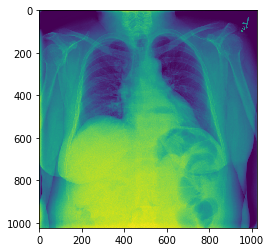

In [5]:
img=mpimg.imread('/mnt/data/deyingk/xRay/data/images/00006624_000.png')
imgplot = plt.imshow(img)
plt.show()

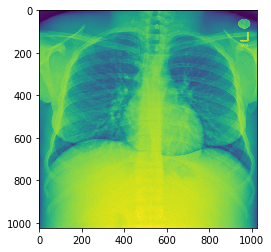

In [6]:
img2=mpimg.imread('/mnt/data/deyingk/xRay/data/images/00005344_000.png')
imgplot = plt.imshow(img2)
plt.show()

In [7]:
img.shape, img2.shape

((1024, 1024), (1024, 1024))

In [8]:
img

array([[ 0.58431375,  0.58039218,  0.58039218, ...,  0.01176471,
         0.00784314,  0.        ],
       [ 0.58823532,  0.57647061,  0.57254905, ...,  0.00392157,
         0.00392157,  0.        ],
       [ 0.56470591,  0.55686277,  0.56470591, ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.87450981,  0.83529413,  0.8392157 , ...,  0.23921569,
         0.22352941,  0.12156863],
       [ 0.86274511,  0.83137256,  0.83137256, ...,  0.24313726,
         0.25098041,  0.13333334],
       [ 0.89019608,  0.83529413,  0.82745099, ...,  0.25882354,
         0.26274511,  0.13333334]], dtype=float32)

1.resize&color normalization 2.detection(bounding box)

In [9]:
#here it is!
###############
################
###########
#Remember to change the validation loader path, due to different data set splitting!


import torchvision.models as models
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.image as mpimg
import torch
from torch.utils.data import Dataset
from skimage.color import gray2rgb
import cv2
from torchvision import transforms, utils
from skimage import io, transform
from torch.utils.data import DataLoader
import torchvision.models as models
import time
from torch.autograd import Variable
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd
import torch
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as transforms
from torch import nn,optim
import argparse
import math
#import setproctitle
import shutil
import sys
class MultiLabelDataset(Dataset):
    def __init__(self, csv_path, img_path, transform=None):
        tmp_df = pd.read_csv(csv_path)
        
        self.mlb = MultiLabelBinarizer()
        self.img_path = img_path
        self.transform = transform

        self.X = tmp_df['Image Index']

         
        a = self.mlb.fit_transform(tmp_df['Finding Labels'].str.split('|')).astype(np.float32)
        self.y =a
        NoFindingIndex=list(self.mlb.classes_).index('No Finding')
        self.y =np.delete(a,NoFindingIndex,1)         #delete the classification for "No Finding"
    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_path, self.X[index]))
        img = img.resize((224,224))
        img = img.convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        label = torch.from_numpy(self.y[index])

        return img, label

    def __len__(self):
        return len(self.X.index)

normMean = [0.49139968, 0.48215827, 0.44653124]
normStd = [0.24703233, 0.24348505, 0.26158768]
normTransform = transforms.Normalize(normMean, normStd)

trainTransform = transforms.Compose([
    #transforms.Scale(256),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normTransform
])

valTransform = transforms.Compose([
    #transforms.Scale(256),
    transforms.ToTensor(),
    normTransform
])


#data_train = MultiLabelDataset('/mnt/data/deyingk/xRay/data/labels_split_choice_2/resample_train.csv','/mnt/data/deyingk/xRay/data/images/',trainTransform)
data_val = MultiLabelDataset(val_label_path,'/mnt/data/deyingk/xRay/data/images/',valTransform)



#trainLoader = DataLoader(
#    data_train, batch_size=8, shuffle=True,num_workers=6)
valLoader = DataLoader(
    data_val, batch_size=8, shuffle=False,num_workers=6)


#dataset_train_len=len(data_train)
dataset_val_len=len(data_val)


densenet = models.densenet121(num_classes=14)
densenet = densenet.cuda()

parameter=0
for param in densenet.parameters():
    parameter+=param.data.nelement()
print ('Total trainable parameters are {}'.format(parameter))

pass
#trainF#



def get_loss_function(output, target):
    possiblility_vec = 1/(1+(-output).exp())
    #return np.sum(-target*np.log(possiblility_vec)-(1-target)*np.log(1-possiblility_vec))
    loss = -target*possiblility_vec.log()-(1-target)*(1-possiblility_vec).log()
    return loss.mean()

#-------------Training------------------#
def train_model(model, optimizer, num_epochs=25):
    since = time.time()
    best_model_wts = model.state_dict()
    best_acc = 0.0 
    
    # nProcessed = 0
    running_loss = 0.0
    running_corrects = 0
    nTrain = len(trainLoader.dataset)
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        model.train()
        for batch_idx, (data, target) in enumerate(trainLoader):
            data, target = Variable(data.cuda()),Variable(target.cuda())
#             print target
            optimizer.zero_grad()
            output = model(data)
            pred_temp = torch.sigmoid(output)
            preds = (pred_temp > 0.5).type(torch.FloatTensor)
#             print preds
            loss = get_loss_function(output, target)
            loss.backward()
            optimizer.step()
            # nProcessed += len(data)
            running_loss += loss.data[0]
            running_corrects += np.sum(preds.data.cpu().numpy()[0] == target.data.cpu().numpy()[0])

        epoch_loss = running_loss / len(data_train)
        epoch_acc = running_corrects / len(data_train)

        print('{} Loss: {:.4f} Acc: {:.4f}'.format('train', epoch_loss, epoch_acc))

            # deep copy the model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


#optimizer=optim.Adam(densenet.parameters(),lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0)
#model_ft = train_model(densenet, optimizer,num_epochs=25)
    #test(args, epoch, net, testLoader, optimizer, testF)
    #torch.save(net, os.path.join(args.save, '%d.pth' % epoch))
    # with open('our_trained_densenet_epoch_'+str(epoch)+'.npy','w') as f:
    #   pickle.dump(densenet,f)

Total trainable parameters are 6968206


In [10]:
def prediction(val_loader,net):
    #net.eval()
    predict_container =  np.zeros((0, 14))
    target_container = np.zeros((0, 14))
    for i, (data, target) in enumerate(val_loader):
        data = Variable(data.float().cuda(), volatile = True)
        target = Variable(target.float().cuda(), volatile = True)
        output = net(data)
        pred_temp = 1/(1+(-output).exp())
        #preds = (pred_temp > 0.5)
        #print preds.data.cpu().numpy()
        predict_container = np.concatenate((predict_container,pred_temp.data.cpu().numpy()),axis=0)
        target_container = np.concatenate((target_container,target.data.cpu().numpy()),axis=0)
        
    return predict_container, target_container

In [11]:
!ls

CAM_00006819_003.jpg  Mdf_lossfun  orig_lossfun   Xray_train_p3.py
cam.ipynb	      nohup.out    split_choice2  Xray_train.py


# The auc portion begins in the following

In [12]:
#import pickle
#densenet = pickle.load(open('/mnt/data/deyingk/xRay/data/no_oversample_weight/weighetedLossFun/weighetedLossFun_densenet_epoch_25.pkl', 'rb'))
#densenet.eval()
#y_score, y_test = prediction(valLoader,densenet)

should change the save path and the path for loading pickel

In [15]:
import pickle
from sklearn.metrics import roc_curve, auc

auroc_dict ={}
for epoch_i in range(70):
    densenet = pickle.load(open(weight_load_path+'origLossFun_densenet_epoch_'+str(epoch_i)+'.pkl', 'rb'))
    densenet.eval()
    y_score, y_test = prediction(valLoader,densenet)
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(14):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    auroc_dict['epoch_'+str(epoch_i)]=roc_auc
    print(epoch_i,auroc_dict['epoch_'+str(epoch_i)])
    with open(auroc_save_path+'auroc_dict.pkl','wb') as f:
        pickle.dump(auroc_dict,f)





0 {0: 0.73395141862495106, 1: 0.85742894661287905, 2: 0.76848970896977387, 3: 0.88377144278685482, 4: 0.81584808209841964, 5: 0.79535452594332001, 6: 0.72100968457080628, 7: 0.87001522070015225, 8: 0.66608020819595204, 9: 0.71585709564201594, 10: 0.64018656665715501, 11: 0.71403192131609405, 12: 0.6609637921630398, 13: 0.79417433610496613}
1 {0: 0.72865395586041937, 1: 0.86325538305875638, 2: 0.74940952445358744, 3: 0.87214915074369814, 4: 0.8218600119582854, 5: 0.79208653338647306, 6: 0.73099036728767197, 7: 0.83824514280598084, 8: 0.65988383620189173, 9: 0.74265341470601276, 10: 0.64037556684615515, 11: 0.72120913409132836, 12: 0.65710559047371442, 13: 0.80423914698668708}
2 {0: 0.71159643419271024, 1: 0.8616547762583654, 2: 0.73601400677434214, 3: 0.84554297801692768, 4: 0.81639632684666674, 5: 0.75671001324902787, 6: 0.70061244862769512, 7: 0.758234398782344, 8: 0.65697190914496206, 9: 0.72240960305395263, 10: 0.61434897464309235, 11: 0.65240211676812399, 12: 0.61615003084012587, 1

24 {0: 0.65445768868605358, 1: 0.81912218154986705, 2: 0.63104018494287861, 3: 0.80814988427687418, 4: 0.77920945822018584, 5: 0.75589002768292801, 6: 0.61785331829437462, 7: 0.77605873399588154, 8: 0.5789542377270378, 9: 0.71812916065845633, 10: 0.60275588216764686, 11: 0.63391341122905875, 12: 0.58691881655477562, 13: 0.75399881963605841}
25 {0: 0.65000721684204743, 1: 0.83712447199365014, 2: 0.63462460045410507, 3: 0.81536496469683706, 4: 0.77694248254215914, 5: 0.73243157361827715, 6: 0.66185834856676129, 7: 0.80044766765153552, 8: 0.59288763329365057, 9: 0.69193770974412194, 10: 0.59066465684112746, 11: 0.64480500389897877, 12: 0.58785453400824783, 13: 0.77132128288951463}
26 {0: 0.66081675750723401, 1: 0.82936976507475269, 2: 0.64538710540282862, 3: 0.79793359345201376, 4: 0.78378213751607118, 5: 0.7331140533946594, 6: 0.66336120726537284, 7: 0.7289927477840451, 8: 0.59640279668558493, 9: 0.72353809813743308, 10: 0.57600648777119368, 11: 0.65671090749777794, 12: 0.593837454695600

48 {0: 0.68144279278040865, 1: 0.81480438549897927, 2: 0.63947369533333609, 3: 0.78351076042813994, 4: 0.76104240724451611, 5: 0.7386011571356248, 6: 0.65404690599354365, 7: 0.78154534873310055, 8: 0.5855192389341678, 9: 0.71271329689728624, 10: 0.6024050582874112, 11: 0.65137509747446798, 12: 0.60207571888078382, 13: 0.76150023540774647}
49 {0: 0.68335890730138227, 1: 0.83564109123031849, 2: 0.62968714809217274, 3: 0.80146090347086707, 4: 0.76581857742425818, 5: 0.72666390420845128, 6: 0.64701904502612362, 7: 0.77967230727907599, 8: 0.58304766235240046, 9: 0.70955474924576856, 10: 0.58278555705026291, 11: 0.66340258213010017, 12: 0.58697552670347086, 13: 0.76891374629473663}
50 {0: 0.65995163856680394, 1: 0.79617754176822397, 2: 0.63891215233393583, 3: 0.78866785189393984, 4: 0.7683547686840313, 5: 0.72575673626894432, 6: 0.65380783840898193, 7: 0.7429098397349807, 8: 0.59308713287148374, 9: 0.71211054737511836, 10: 0.57580914933856109, 11: 0.64290831320957209, 12: 0.60735932059967479

In [16]:
auroc_dict
len(auroc_dict)

70

In [ ]:
aur

0
1
0
0
1
0
1


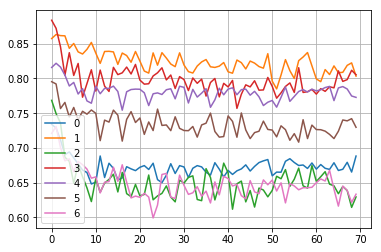

In [17]:
for class_index in range(7):
    ls =[]
    for i in range(len(auroc_dict)):
        ls.append(auroc_dict['epoch_'+str(i)][class_index])
    print (ls.index(max(ls)))        
    plt.plot(range(len(auroc_dict)),np.array(ls),label=class_index)
plt.legend()
plt.grid()
plt.show()

0
0
1
1
1
4
1


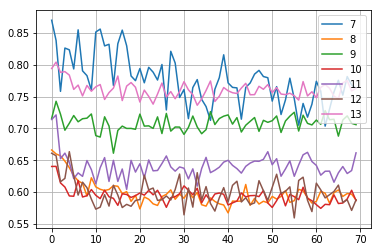

In [18]:
for class_index in range(7,14):
    ls =[]
    for i in range(len(auroc_dict)):
        ls.append(auroc_dict['epoch_'+str(i)][class_index])
    print (ls.index(max(ls))) 
    plt.plot(range(len(auroc_dict)),np.array(ls),label=class_index)
plt.legend()
plt.grid()
plt.show()

The following part is the testing part

In [19]:
def get_auroc_test(testLoader,densenet_chosen):
    y_score, y_test = prediction(testLoader,densenet_chosen)
    # Compute ROC curve and ROC area for each class
    fpr_test = dict()
    tpr_test = dict()
    auroc_test = dict()
    for i in range(14):
        fpr_test[i], tpr_test[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        auroc_test[i] = auc(fpr_test[i], tpr_test[i])
    return auroc_test


In [20]:
data_test = MultiLabelDataset(test_label_path,'/mnt/data/deyingk/xRay/data/images/',valTransform)
testLoader = DataLoader(
    data_test, batch_size=16, shuffle=False,num_workers=6)

In [21]:
#for weighetedLossFun_densenet, we choose epoch_21.
#densenet_chosen = pickle.load(open('/mnt/data/deyingk/xRay/data/no_oversample_weight/weighetedLossFun/weighetedLossFun_densenet_epoch_21.pkl', 'rb'))

#for original lossFun, choose epoch_17
#for original lossFun, split choice 2, choose epoch_20
#for mdf_lossFun, split choice 2, choose epoch_20
#for original lossFun, split choice 1, choose epoch_1
densenet_chosen = pickle.load(open(weight_load_path+'origLossFun_densenet_epoch_1.pkl', 'rb'))
densenet_chosen.eval()
auroc_test = get_auroc_test(testLoader,densenet_chosen)
print (auroc_test)

{0: 0.74518079179500107, 1: 0.86023670280583109, 2: 0.75362233178384708, 3: 0.86081896672161839, 4: 0.82745176866247427, 5: 0.76598734432317639, 6: 0.69678160965483782, 7: 0.7955067022683644, 8: 0.66291940176447961, 9: 0.7362038406763548, 10: 0.63171256127852093, 11: 0.72654329071193047, 12: 0.64538122929806141, 13: 0.80088642183614733}


In [ ]:
with open(auroc_save_path+'auroc_test.pkl','wb') as f:
    pickle.dump(auroc_test,f)

In [ ]:
!pwd

# The following codes could be used to plot the roc curve.

In [ ]:
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(14):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Cardiomegaly')
plt.legend(loc="lower right")
plt.show()

In [ ]:
roc_auc

In [ ]:
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('class0, Atelectasis')
plt.legend(loc="lower right")
plt.show()

In [ ]:
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('class2,Consolidation')
plt.legend(loc="lower right")
plt.show()

In [ ]:
plt.plot(fpr[3], tpr[3], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[3])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('class3,Edama')
plt.legend(loc="lower right")
plt.show()

In [ ]:
plt.plot(fpr[4], tpr[4], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[4])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('class4,Effusion')
plt.legend(loc="lower right")
plt.show()

In [ ]:
plt.plot(fpr[5], tpr[5], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[5])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('class5,Emphysema')
plt.legend(loc="lower right")
plt.show()

In [ ]:
plt.plot(fpr[6], tpr[6], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[6])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('class6,Fibrosis')
plt.legend(loc="lower right")
plt.show()

In [ ]:
plt.plot(fpr[7], tpr[7], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[7])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('class7, Hernia')
plt.legend(loc="lower right")
plt.show()

In [ ]:
plt.plot(fpr[8], tpr[8], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[8])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('class8,Infiltration')
plt.legend(loc="lower right")
plt.show()

In [ ]:
plt.plot(fpr[9], tpr[9], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[9])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('class9,Mass')
plt.legend(loc="lower right")
plt.show()

In [ ]:
plt.plot(fpr[10], tpr[10], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[10])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('class10, Nodule')
plt.legend(loc="lower right")
plt.show()

In [ ]:
plt.plot(fpr[11], tpr[11], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[11])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('class11,Pleural Thickening')
plt.legend(loc="lower right")
plt.show()

In [ ]:
plt.plot(fpr[12], tpr[12], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[12])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('class12, Pneumonia')
plt.legend(loc="lower right")
plt.show()

In [ ]:
plt.plot(fpr[13], tpr[13], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[13])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('class13,Pneumothrax')
plt.legend(loc="lower right")
plt.show()

# The heatmap starts in the following

In [ ]:
import io
from PIL import Image
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
import numpy as np
import cv2

# input image

# hook the feature extractor
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

#In case that densenet is of DataParallel structure.
densenet = densenet_chosen
if (str(type(densenet))=="<class 'torch.nn.parallel.data_parallel.DataParallel'>"):
    densenet=densenet._modules.get('module')

densenet._modules.get('features').register_forward_hook(hook_feature)

# get the softmax weight
params = list(densenet.parameters())
weight_softmax = np.squeeze(params[-2].data.cpu().numpy())
#print weight_softmax

def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    #print bz, nc, h, w
    
    output_cam = []
    for idx in class_idx:
        
        cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam
normalize = transforms.Normalize(
   mean = [0.49139968, 0.48215827, 0.44653124],
    std = [0.24703233, 0.24348505, 0.26158768]
)
preprocess = transforms.Compose([
   transforms.Scale((224,224)),
   transforms.ToTensor(),
   normalize
])
img = Image.open('/mnt/data/deyingk/xRay/data/images/00006819_003.png').resize((224,224)).convert('RGB')
#print np.array(img).shape
img_tensor = preprocess(img)
img_variable = Variable(img_tensor.unsqueeze(0).cuda())
logit = densenet(img_variable)


h_x = F.softmax(logit).data.squeeze()


probs, idx = h_x.sort(0, True)

print(idx)

# generate class activation mapping for the top1 prediction
CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])

# render the CAM and output
height, width, _ =  np.array(img).shape
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap * 0.3 + np.array(img) * 0.5
cv2.imwrite('CAM_00006819_003.jpg', result)

In [ ]:
!ls

In [ ]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('CAM_00006819_003.jpg')
imgplot = plt.imshow(img)
plt.show()